### Context

This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns to better target marketing to increase the success ratio with a minimal budget.

#### Task:
The department wants to build a model that will help them identify the potential customers who have a higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

In [2]:
data = pd.read_excel('bank_personal_loan_modelling.xlsx', sheet_name = 'Data')  #you can also do sheet_name = 1(because its second sheet)

#### 1. Explore Dataset

In [25]:
data.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


#### Initial Observations

1. data has 5000 rows and 14 columns
2. no presence of missing values
3. data looks really clean and would require very little cleaning

In [26]:
cleaned_data = data.drop(['ID','ZIP Code'], axis = 1)

In [13]:
cleaned_data['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

In [27]:
#separate majority and minority class

yes_loan = cleaned_data[cleaned_data['Personal Loan'] == 1]
no_loan = cleaned_data[cleaned_data['Personal Loan'] == 0]

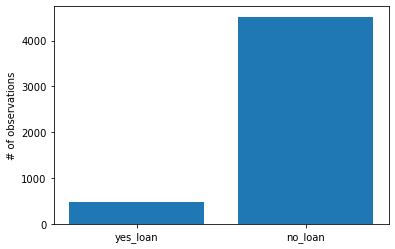

In [28]:
#Get all possible labels
labels = cleaned_data['Personal Loan'].unique()
heights = [len(yes_loan),len(no_loan)]
plt.bar(labels,heights)
plt.xticks(labels,['yes_loan','no_loan'])
plt.ylabel("# of observations")
plt.show()

In [29]:
from sklearn.utils import resample

#choose class size

class_size = 2500 #mean of major and minor class


downsampled_no_loan = resample(no_loan,
                          replace = False,
                          n_samples = class_size,
                          random_state = 27)


upsampled_yes_loan = resample(yes_loan,
                              replace = True,  #sample with replacement(we want to duplicate observation)
                              n_samples = class_size,
                              random_state = 27)


# Combine both to get a balanced dataset
balanced_data = pd.concat([downsampled_no_loan, upsampled_yes_loan])

# Optional: shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=27).reset_index(drop=True)

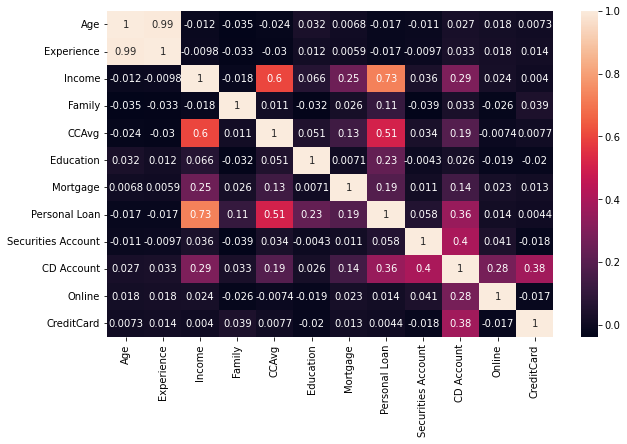

In [30]:
#check the relationship between our features and target

plt.figure(figsize=[10,6])
sb.heatmap(balanced_data.corr(),annot=True);

In [32]:
balanced_data = balanced_data.drop(['Age', 'Experience'], axis = 1)

KeyError: "['Age', 'Experience'] not found in axis"

#### 📉 Age & Experience both have:

- Very high correlation with each other (≈ 0.99)

- Very low correlation with the target (≈ 0.017)

### Why drop them?

- They don’t help predict whether someone will take a personal loan (no correlation with the target).

- Including either may add noise, not signal.

- Keeping them just because they “seem” important is tempting — but your data is telling you otherwise.



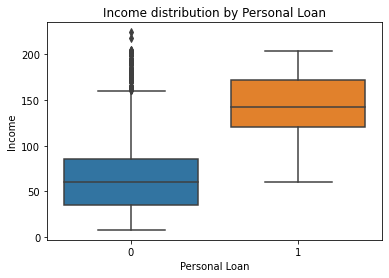

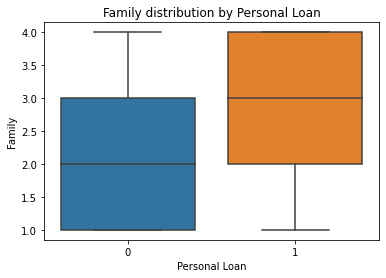

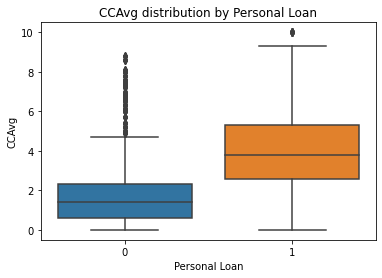

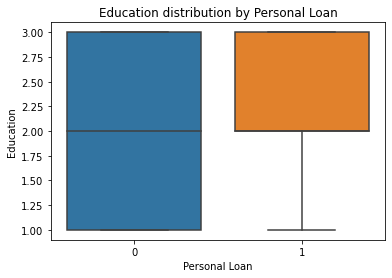

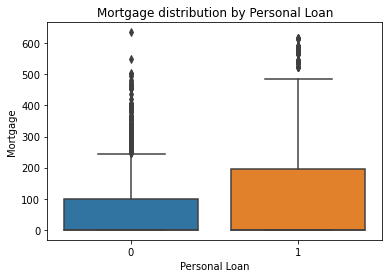

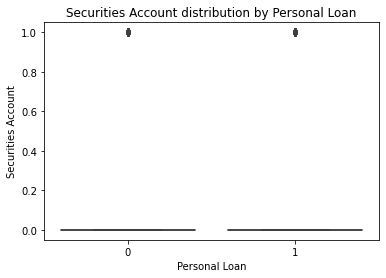

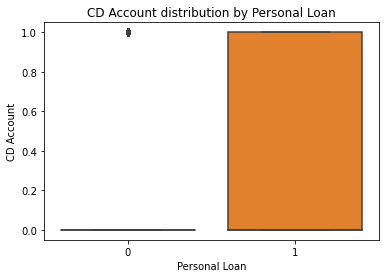

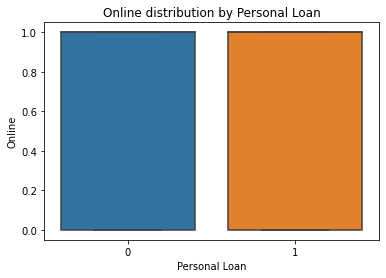

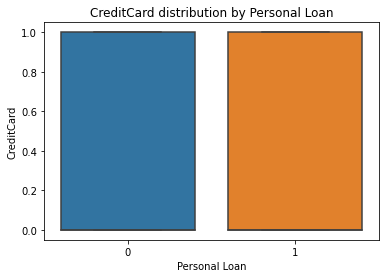

In [ ]:
#check of each feature against the personal loan

features = balanced_data.drop(['Personal Loan'], axis = 1)

for feature in features:
    sb.boxplot(data=balanced_data,x='Personal Loan', y = feature)
    plt.title(f"{feature} distribution by Personal Loan")
    plt.show()

#### 3. Feature Engineering

✅ 1. DTI Ratio (Debt-to-Income Ratio)

This shows how much debt a customer has relative to their income.

In [33]:
balanced_data['DTI'] = balanced_data['Mortgage'] / (balanced_data['Income'] + 1)

> +1 avoids division by zero (if any income is 0).


✅ 2. Loan Affordability Index (LAI)

Simulates how much someone could reasonably borrow based on their income and spending behavior.

In [34]:
balanced_data['Loan_Affordability'] = balanced_data['Income'] / (balanced_data['CCAvg'] + 1)

3. Total_Assets

In [35]:
balanced_data['Total Assest'] = balanced_data['Income'] + balanced_data['Mortgage'] 

#### 4. Modelling

In [36]:
X = balanced_data.drop(['Personal Loan'],axis=1)
y = balanced_data['Personal Loan']

In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Tree Based Models

**Random Forest**

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier()
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

**Decision Tree Model**

In [39]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

pred_dt = dt.predict(X_test)

**XGB model**

In [40]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train,y_train)

pred_xg = xg.predict(X_test)

#### Linear Models

**SVM Model**

first lets scale our numerical features

In [42]:
numerical_features = balanced_data[['Income', 'Family', 'CCAvg', 'Mortgage', 'DTI', 'Loan_Affordability', 'Total Assest']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_numerical = pd.DataFrame(scaler.fit_transform(numerical_features), 
                                columns=numerical_features.columns,
                                index=numerical_features.index)

# Drop the original numerical columns and replace with scaled ones
balanced_data_scaled = balanced_data.drop(columns=numerical_features.columns)
balanced_data_scaled = pd.concat([balanced_data_scaled, scaled_numerical], axis=1)

In [43]:
X_scaled = balanced_data_scaled.drop(['Personal Loan'], axis = 1)
y_scaled = balanced_data_scaled['Personal Loan']

X_scaled_train,X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled,
                                                                                y_scaled,test_size=0.2,
                                                                                random_state=41)

In [44]:
from sklearn.svm import SVC

sv = SVC()
sv.fit(X_scaled_train,y_train)

pred_sv = sv.predict(X_scaled_test)

**logistic regression**

In [45]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_scaled_train,y_scaled_train)

pred_lr = lr.predict(X_scaled_test)

#### 5. Model Performance 

In [47]:
from sklearn.metrics import f1_score

dt_f1 = f1_score(y_test, pred_dt)
rf_f1 = f1_score(y_test, pred_rf)
xg_f1 = f1_score(y_test, pred_xg)
lr_f1 = f1_score(y_scaled_test, pred_lr)
sv_f1 = f1_score(y_scaled_test, pred_sv)

In [48]:
result = {'F1_Score' : {'decision_tree': dt_f1,
                        'random forest' : rf_f1,
                        'xg boost': xg_f1,
                        'logistic reg' : lr_f1,
                        'SVC' : sv_f1}}

pd.DataFrame(result)

,F1_Score
SVC,0.491736
decision_tree,0.984864
logistic reg,0.870681
random forest,0.987854
xg boost,0.982880


#### 6. Model Improvement

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1 = make_scorer(f1_score, average='binary')

In [52]:
###lets do this for other models

#get the mean of each scores
rf_score = cross_val_score(rf, X, y, cv=5, scoring=f1).mean()
dt_score = cross_val_score(dt, X,y, cv=5,scoring=f1).mean()
xg_score = cross_val_score(xg, X,y, cv=5,scoring=f1).mean()
lr_score = cross_val_score(lr, X_scaled,y_scaled, cv=5,scoring=f1).mean()
sv_score = cross_val_score(sv, X_scaled,y_scaled, cv=5,scoring=f1).mean()

In [53]:
f1_scores = {'F1_Score' : {'decision_tree': dt_score,
                        'random forest' : rf_score,
                        'xg boost': xg_score,
                        'logistic reg' : lr_score,
                        'SVC' : sv_score}}

pd.DataFrame(f1_scores)

,F1_Score
SVC,0.953102
decision_tree,0.991290
logistic reg,0.893814
random forest,0.993251
xg boost,0.992854


### Final Note

#### Why Each Model?
I chose these models because I’m dealing with a classification problem — predicting whether someone is likely to get a loan (yes or no).

While exploring the dataset, I noticed that many of the features didn’t show strong linear relationships with the target, which influenced my decision to include tree-based models like Random Forest and XGBoost — models that can handle non-linear patterns and interactions.

However, I also included linear models like Logistic Regression and Support Vector Classifier (SVC) because:

- They are fast and easy to interpret, which makes them great baseline models.

- They work well when the data is linearly separable or close to it.

- Logistic Regression provides probability outputs, which can be useful for threshold tuning.

- SVC with a linear kernel can handle high-dimensional spaces efficiently and is robust to overfitting when regularized properly.

- Even if the dataset is not perfectly linear, these models can still perform well with proper feature scaling, and give insight into which features may influence the prediction.

Including them helped me compare simple, interpretable models against more complex, high-capacity ones — allowing for a better evaluation of trade-offs between performance, interpretability, and training time.



#### What surprised you?

What surprised me was the performance of my SVC model before and after cross-validation.
Before applying cross-validation, the F1 score was around 49%, which made it seem like one of the weakest models.
However, after performing cross-validation, the F1 score jumped significantly to about 95%, revealing that the model was likely underestimated due to the initial train-test split.

This showed me the importance of using cross-validation for a more reliable evaluation of model performance.


#### Which metric matters most

I would say the F1 score matters most in this case because it provides a better balance between precision and recall, especially when working with imbalanced target classes.

Unlike accuracy, which only measures overall correctness, the F1 score focuses on how well the model correctly identifies positive cases while minimizing false positives and false negatives.

Since predicting loan approval involves a risk in both directions (wrongly approving or wrongly rejecting), the F1 score gives a more meaningful measure of the model's real-world performance.
